In [4]:
#A place for the imports.
import seaborn as sbn
import pandas as pd
import numpy as np
import warnings
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,Lasso,LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,r2_score, mean_absolute_error
from sklearn.decomposition import PCA
%matplotlib inline

# Data exploration

In [5]:
#To import abalone data from the Internet uncomment the line below:
raw_data=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',header=None)
#Alternatively uncomment the line below to load local copy of the file:
#raw_data=pd.read_csv('data/abalone.data',header=None)
warnings.filterwarnings('ignore')

In [6]:
#Define finction to draw features vs. age of abalone to examine data
def draw_figures(raw_data,label=None):
    if label in raw_data.columns:
            plt.figure(figsize=(8,4))
            plt.scatter(raw_data['age'],raw_data[label])
            plt.axes().set_ylabel(label)
            plt.axes().set_xlabel('age')
            plt.show() 
    else:
        fig=plt.figure(figsize=(16,16))
        for i in range(7):
            name=fig.add_subplot(4,2,i+1)
            name.scatter(raw_data['age'],raw_data[raw_data.columns[i]])
            name.set_ylabel(raw_data.columns[i])
            name.set_xlabel('age')
        plt.show()    

In [7]:
#Define function to draw residuals histogram
def draw_res_hist(y_test,y_pred):
    plt.figure(figsize=(12,6))
    y_pred=pd.Series(y_pred)
    residual=y_test-y_pred.values
    residual.hist(grid=True,bins=(residual.max().astype(int)-residual.min().astype(int)+1))
    plt.axes().set_xlabel('prediction residuals')
    plt.show()

In [8]:
#Define function to draw predicted rings vs. actual rings
def draw_pred_act(y_test,y_pred):
    plt.scatter(y_test,y_pred)
    plt.plot((1,29),(1,29),c='r')
    plt.axis([1,29,1,29])
    plt.axes().set_xlabel('actual rings')
    plt.axes().set_ylabel('predicted rings')
    plt.show()

In [9]:
#Change labels, slicing data for sex violin plot
labels={0:'sex',1:'length',2:'diameter',3:'height',4:'whole_weight',
       5:'shucked_weight',6:'viscera_weight',7:'shell_weight',8:'rings'}
raw_data.rename(columns=labels,inplace=True)
sex_data=raw_data.loc[:,['sex','rings']]
#Examine data, adding a cloumn with age of abalone
raw_data['age']=raw_data['rings']+1.5

In [10]:
#Examine data
raw_data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5


In [11]:
raw_data.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,11.433684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,2.500000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,9.500000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,10.500000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,12.500000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,30.500000


In [12]:
#Transform sex into three separate variables
raw_data['male'] = (raw_data['sex']=='M').astype(int)
raw_data['female'] = (raw_data['sex']=='F').astype(int)
raw_data['infant'] = (raw_data['sex']=='I').astype(int)
raw_data=raw_data.drop(['sex'],axis=1)

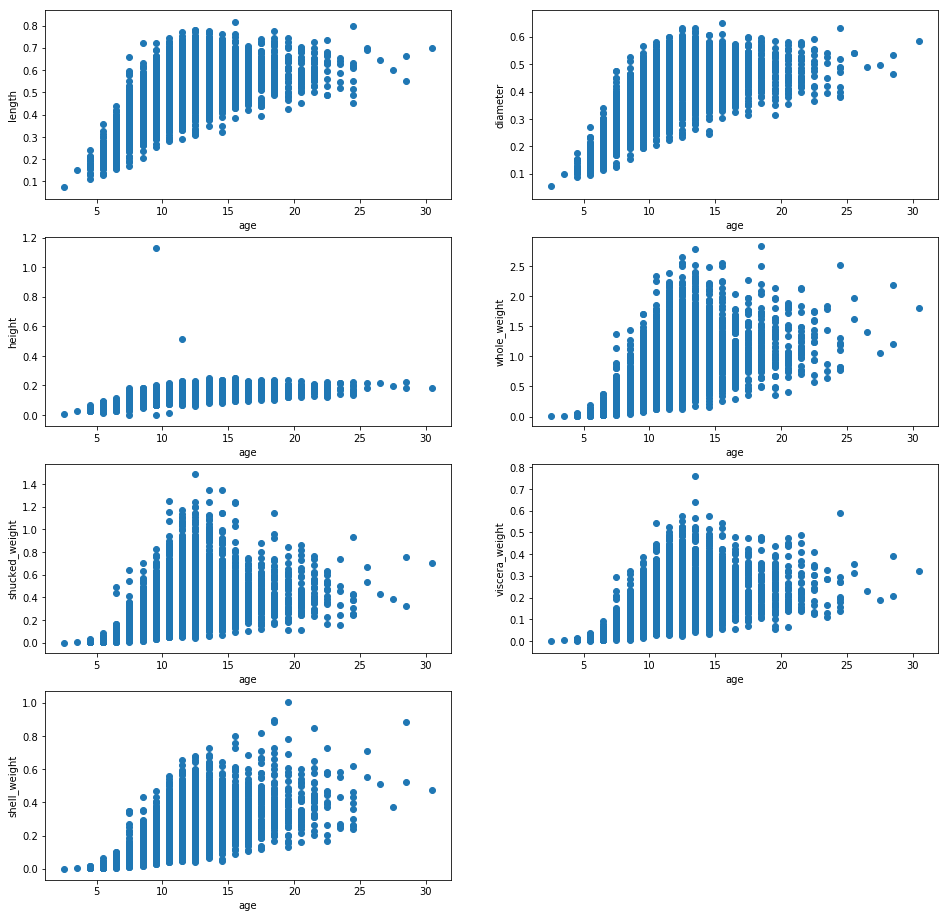

In [13]:
draw_figures(raw_data)

Looking at graphs and data description one can see that there are abnormal instances in 'height', i.e. instances of values of 0 (found from DF.describe) and larger than expected values (found from graph).
I inspect such instances below.

In [14]:
#Inspect instances of height==0
raw_data[raw_data['height']==0]

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age,male,female,infant
1257,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8,9.5,0,0,1
3996,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6,7.5,0,0,1


In [15]:
#Inspect instances of height larger than expected
raw_data[raw_data['height']>0.5]

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age,male,female,infant
1417,0.705,0.565,0.515,2.210,1.1075,0.4865,0.5120,10,11.5,1,0,0
2051,0.455,0.355,1.130,0.594,0.3320,0.1160,0.1335,8,9.5,0,1,0


Then, one can see by comparing graphs, for example for length and diameter, that these parameters seem to be highly correlated.
Let's check the correlation coefficients and plot them on a graph below: 

                  length  diameter    height  whole_weight  shucked_weight  \
length          1.000000  0.908122  0.734706      0.872534        0.835612   
diameter        0.908122  1.000000  0.747600      0.873762        0.824481   
height          0.734706  0.747600  1.000000      0.771342        0.712036   
whole_weight    0.872534  0.873762  0.771342      1.000000        0.879604   
shucked_weight  0.835612  0.824481  0.712036      0.879604        1.000000   
viscera_weight  0.826290  0.820319  0.748397      0.870743        0.809665   
shell_weight    0.823616  0.840237  0.781861      0.862203        0.764496   

                viscera_weight  shell_weight  
length                0.826290      0.823616  
diameter              0.820319      0.840237  
height                0.748397      0.781861  
whole_weight          0.870743      0.862203  
shucked_weight        0.809665      0.764496  
viscera_weight        1.000000      0.797572  
shell_weight          0.797572      1.000000  

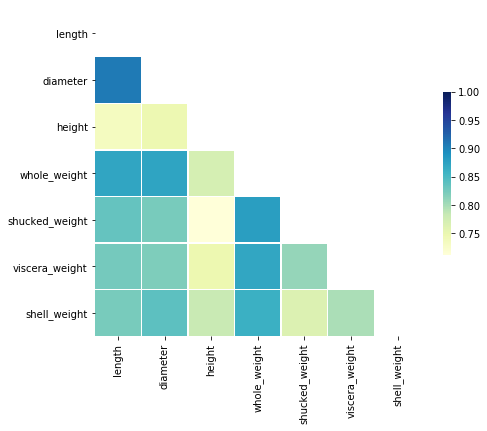

In [16]:
#Correlation coefficicent matrix 
corr = raw_data.loc[:,'length':'shell_weight'].corr('kendall')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
sbn.heatmap(corr, mask=mask,cmap='YlGnBu', vmax=1,square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);
print(corr)
plt.show()

Most of the columns are highly correlated, especially pairs:
    length-diameter, shucked_weight-whole_weight. Below is the graph for diameter vs length. Perfectly correlated data would produce a graph in a shape of a straight line. This one is pretty close to it.
    
It is then reasonable to assume that in future analysis some of the columns might be excluded form the model,
as they don't provide much more new information.

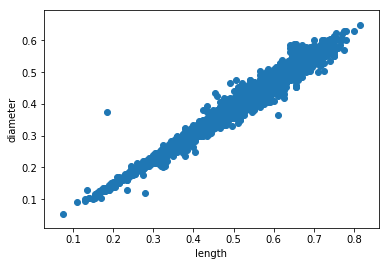

In [17]:
#Plot diameter vs length to see that they're highly correlated
plt.scatter(raw_data['length'],raw_data['diameter'])
plt.axes().set_xlabel('length')
plt.axes().set_ylabel('diameter')
plt.show()

Last thing to do is to look at the violin graph for sex distribution (below). One can see that if an abalone was marked as Infant, it is in general more likely to be younger, whereas the difference between Male and Female is not so obvious.

As Male can't be Female, I can drop Male dummy variable without any consequences. By keeping the Female and Infant column, I assure that no information is lost.

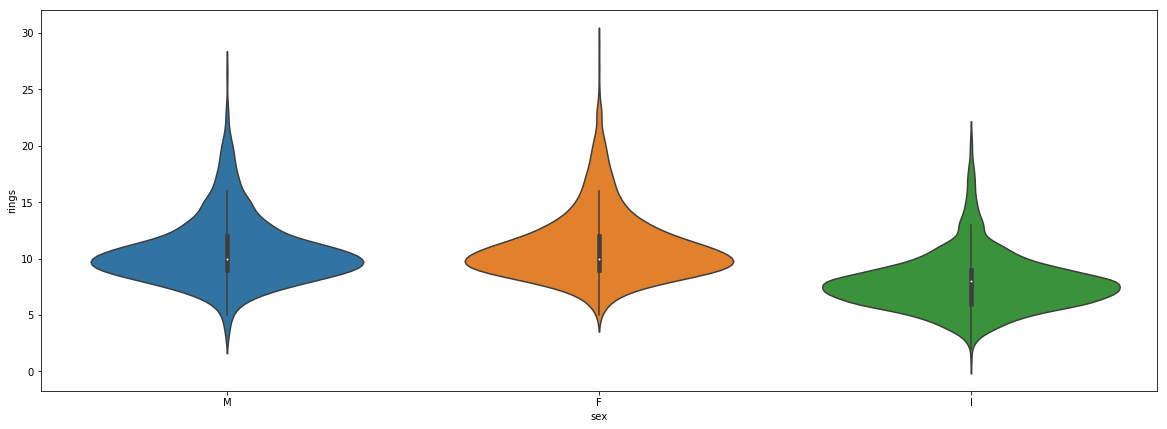

In [18]:
#Plot sex vs. population at given no. of rings 
plt.figure(figsize = (20,7))
sbn.violinplot(x = 'sex', y = 'rings', data = sex_data)
plt.show()

# Supervised learning

In [19]:
# Remove instances of height==0 and height>0,5
raw_data = raw_data[raw_data['height']>0]
raw_data = raw_data[raw_data['height']<0.5]

As there are only 4 points with strange behavior, I've decided to remove them. However for more instances like that I'd consider ather method for dealing with this situation.
Firstly, let's take a look at the data after removing rows with height==0 and height much larger than for the rest of the dataset. Apart from removing suspicious points, the rest of the data looks ok.

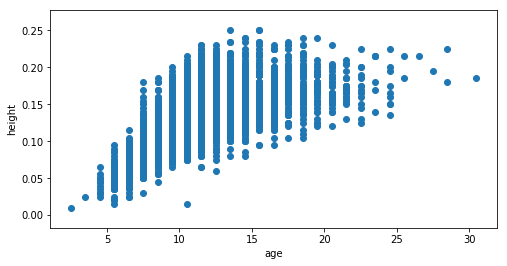

In [20]:
draw_figures(raw_data,label='height')

Now let's decide what kind of problem I deal with.
Based on the data I want to predict how many rings there are in abalone's shell (remember, this number translates directly into abalone's age simply by adding 1.5 to it).
I decided to go with classification and regression algorythms. In the previous section I added a column called 'age' to the dataset. However, as abalones age is not an integer, I decide to use no. of rings as classes(for classification algorythm). There are 28 classes (there are no abalone of age 28 in the dataset).

In [21]:
#Separate data from target
abalone_target=raw_data['rings']
abalone_data=raw_data.drop(['age','rings','male'],axis=1)

In [22]:
#Shuffle and split data for training model, train 75%, test 25%
#Set random state for direct comparison between models accuracy
X_train, X_test, y_train, y_test = train_test_split(abalone_data, abalone_target,random_state=87)

I chose K Nearest Neighbours as my first supervised learning algorythm.
It's an example of a 'lazy' learning algorythm, as it doesn't create a prediction model, but rather it memorizes training dataset. To assign a class to an unknown datapoint, it searches for the nearest point (from training dataset) to the unknown datapoint and once it finds it, the same class is assigned to the unknown datapoint. You can tune this model by changing the number of nearest neighbours it looks for.
If you ran knn algorythm on train dataset with number of neighbours=1, it score will be 1 (100% accuracy). This is because it memorizes the whole training set and it's a clear example of overfitting. 

In [23]:
#Predict no. of rings using KNN model
knn = KNeighborsClassifier(n_neighbors=5)
#Train the algorythm
knn.fit(X_train, y_train)
#Evaluate prediction
tic = time.time()
y_pred_knn = knn.predict(X_test)
toc = time.time()
print(f'{(toc-tic)*1000:.4f} ms elapsed')
train_score_knn=knn.score(X_train, y_train)
test_score_knn=knn.score(X_test, y_test)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
print(f'Mean absolute error: {mae_knn:.4f} Prediction score: {test_score_knn:.4f}')
print(f'Train score: {train_score_knn:.4f}')

19.3276 ms elapsed
Mean absolute error: 1.7692 Prediction score: 0.2356
Train score: 0.4516


Let's look at the histogram of residuals from this algorithm.
If the prediction is perfect, all residuals should be equal to 0.

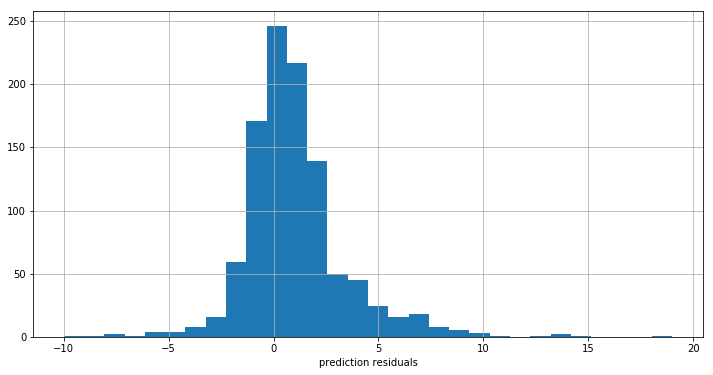

In [24]:
draw_res_hist(y_test,y_pred_knn)

Another way of checking if the prediction works is to plot predicted no. of rings versus the actual number of rings. For perfect prediction this graph would look like a straight line.

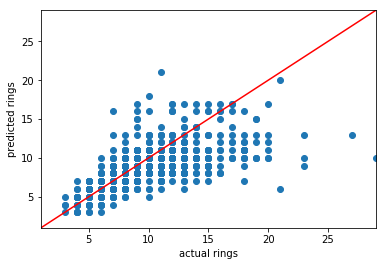

In [25]:
draw_pred_act(y_test,y_pred_knn)

I chose Linear Regression as my second supervised learning algorythm.
It's an example of regression model rather than classification one. Instead of trying to assign a class to an unknown datapoint, it calculates the predicted value for this datapoint, without the assumption that it has to be an integer (as no. of rings is in our case).
This algorythm searches for a linear function that takes height, length etc. as variables and number of rings as a result. It has no hyperparameters to tune. 

In [26]:
#Predict no. of rings using Linear regression model
lnr =LinearRegression()
#Train the algorythm
lnr.fit(X_train, y_train)
#Evaluate prediction
tic = time.time()
y_pred_lnr = lnr.predict(X_test)
toc = time.time()
time_lnr=toc-tic
print(f'{(toc-tic)*1000:.4f} ms elapsed')
train_score_lnr=lnr.score(X_train, y_train)
test_score_lnr=lnr.score(X_test, y_test)
mae_lnr = mean_absolute_error(y_test, y_pred_lnr)
print(f'Mean absolute error: {mae_lnr:.4f} Prediction score: {test_score_lnr:.4f}')
print(f'Train score: {train_score_lnr:.4f}')

11.8172 ms elapsed
Mean absolute error: 1.5831 Prediction score: 0.5389
Train score: 0.5449


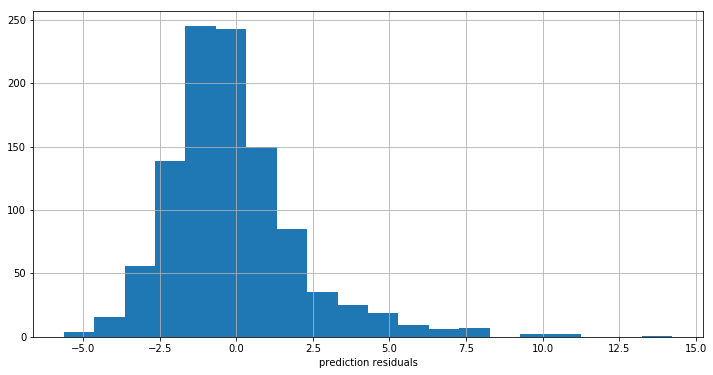

In [27]:
draw_res_hist(y_test,y_pred_lnr)

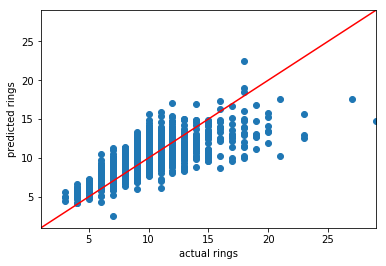

In [28]:
draw_pred_act(y_test,y_pred_lnr)

To conclude this part:
I used two classificaton algorythms, K Nearest neighbours and Linear regression.
They both performed in a similar manner. Main difference is that linear regression has higher accuracy and lower mean absolute error, meaning it predictions are closer to the actual value, but keep in mind it can predict number of rings as a real number rather than an integer, as KNN algorythm does.
Another conclusion I can draw is the fact that the older the abalone, the worse the prediction. It can be a consequence of the fact that after certain age abalones don't grow so fast, so a change in weight or shape is not as big as it used to be when they are younger.

IMPORTANT FACT:
No. of rings can be directly related to the age of abalone by simple addition, so mean absolute error for no. of rings is exactly the same for their age. That is, the two algorythms I chose were on average wrong by around 1.66 years when estimating the age of abalones.


# Dimensionality reduction


Dimensionality reduction is a general approach for high-dimentional data. It is used for for several reasons, to name just few:
1. Reducing data size and increase the computation speed
2. Making data visualisation easier
3. Making data less susceptible to noise and overfitting

In this section I use two approaches. First of them is simple feature selection. As we saw in the previous section, some of the variables, like length and diameter are highly correlated. By deciding to remove one of them I assume that the model will be simpler but remain an acceptable degree of accuracy.
Let's remove diameter, shucked_weight and female variables from our dataset and examine how the model behaves.

In [29]:
#Simple dropping arguments
X_train_red=X_train.drop(['diameter','shucked_weight','female'],axis=1)
X_test_red=X_test.drop(['diameter','shucked_weight','female'],axis=1)
lnr_red =LinearRegression()
#Train the algorythm
lnr_red.fit(X_train_red, y_train)
#Evaluate prediction
tic = time.time()
y_pred_lnr_red = lnr_red.predict(X_test_red)
toc = time.time()
time_rmv=toc-tic
print(f'{(toc-tic)*1000:.4f} ms elapsed')
train_score=lnr_red.score(X_train_red, y_train)
test_score_rmv=lnr_red.score(X_test_red, y_test)
mae_lnr_rmv = mean_absolute_error(y_test, y_pred_lnr_red)
print(f'Mean absolute error: {mae_lnr_rmv:.4f} Prediction score: {test_score_rmv:.4f}')

0.7303 ms elapsed
Mean absolute error: 1.6906 Prediction score: 0.4644


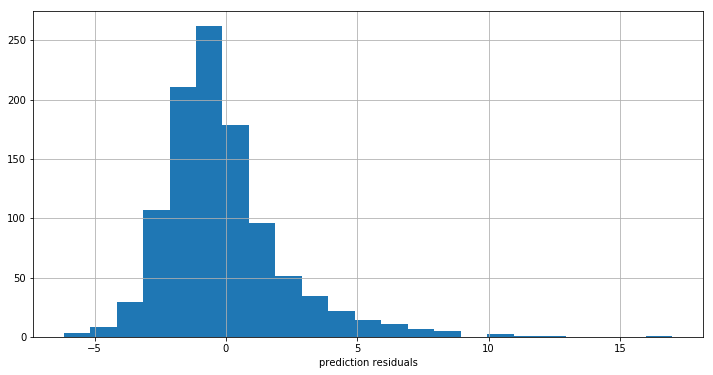

In [30]:
draw_res_hist(y_test,y_pred_lnr_red)

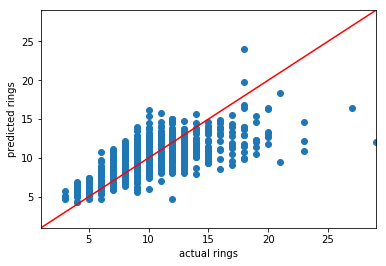

In [31]:
draw_pred_act(y_test,y_pred_lnr_red)

The second method for dimensionality reduction I decided to use is called Principal Component Analysis.
It takes our data (that can be thought of as vectors in a vector space) and project them into another orthogonal space, where component vectors are linear combination of the original ones.
Then, I take a look at how many principal components are needed for explaining the majority of variance in the dataset. Lastly, I drop the unnecessary PCs and perform analysis only based on reduced number of PCs.

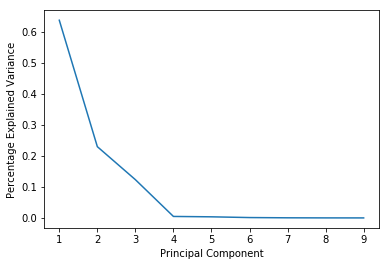

In [32]:
#Use PCA to determine the no. of components responsible for most of the variance
#Start with the same number of components as variables
n_components=9
pca_model = PCA(n_components=n_components)
pca_model.fit(abalone_data)
#Plot the explained variance
plt.plot(range(1,n_components+1),pca_model.explained_variance_ratio_);
plt.xlabel('Principal Component');
plt.ylabel('Percentage Explained Variance');
plt.show()

One can see that first 4 components explain almost all variance in the dataset. Therefore I decide to leave only first 4 PCs and use the same algorythm as before (namely Linear regression):

In [33]:
#Reducing the number of components to 4
pca = PCA(n_components=4)
pca.fit(abalone_data)
rings = raw_data['rings'].values.reshape(len(raw_data),1)
pca_data = np.hstack([pca.transform(abalone_data),rings])
pca_df = pd.DataFrame(pca_data,columns=['PC1','PC2','PC3','PC4','rings'])
train, test = train_test_split(pca_df,random_state=87)
xtrain = train.drop(['rings'],axis=1)
ytrain = train['rings']
xtest = test.drop(['rings'],axis=1)
ytest = test['rings']

lnr_pca = LinearRegression()
lnr_pca.fit(xtrain, ytrain)
tic = time.time()
y_pred_lnr_pca = lnr_pca.predict(xtest)
toc = time.time()
time_pca=toc-tic
print(f'{(toc-tic)*1000:.4f} ms elapsed')
test_score_pca=lnr_pca.score(xtest, ytest)
mae_lnr_pca = mean_absolute_error(ytest, y_pred_lnr_pca)
print(f'Mean absolute error: {mae_lnr_pca:.4f} Prediction score: {test_score_pca:.4f}')

0.4900 ms elapsed
Mean absolute error: 1.6297 Prediction score: 0.5093


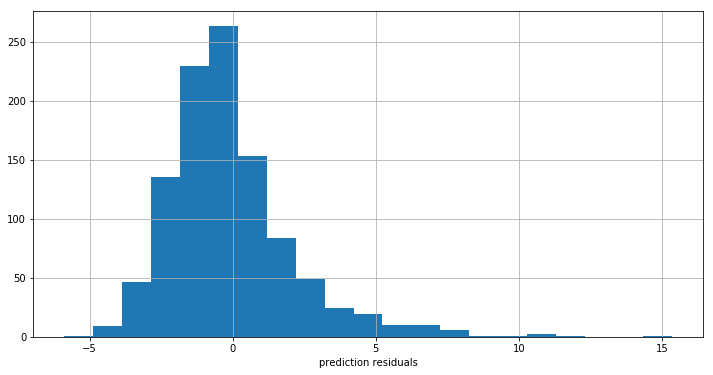

In [34]:
draw_res_hist(ytest,y_pred_lnr_pca)

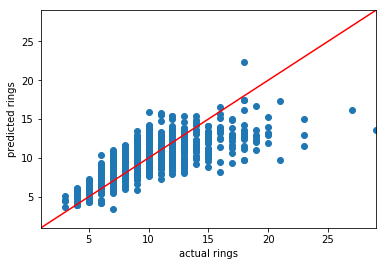

In [35]:
draw_pred_act(ytest,y_pred_lnr_pca)

In [36]:
speed_boost_rmv=(time_lnr-time_rmv)*1000
speed_boost_pca=(time_lnr-time_pca)*1000
pred_loss_rmv=(test_score_lnr-test_score_rmv)*100
pred_loss_pca=(test_score_lnr-test_score_pca)*100

In [37]:
print(f'On the first approach, by removing 3 variables from the dataset, \
I sped up the computation by {speed_boost_rmv:.2f} ms \n and lowered prediction accuracy by {pred_loss_rmv:.2f} %')
print(f'On the second approach, by keeping only 4 PCs from the dataset, \
I sped up the computation by {speed_boost_pca:.2f} ms \n and lowered prediction accuracy by {pred_loss_pca:.2f} %')

On the first approach, by removing 3 variables from the dataset, I sped up the computation by 11.09 ms 
 and lowered prediction accuracy by 7.44 %
On the second approach, by keeping only 4 PCs from the dataset, I sped up the computation by 11.33 ms 
 and lowered prediction accuracy by 2.95 %


# Hyperparameter selection and crossvalidation

Let's now tune the KNN model I used to see what's the optimal number of neighbours K.
With small K there's a problem with overfitting, namely the model predicts well on train set, but behaves poorly on test set. It is due to the fact that for small K the model is too complicated and does not generalise well.

In [38]:
#KNearestneighbours cross-validation (hyperparameter: number of neighbours)
#Create list of K for KNN
neighbours = list(range(1,100))
#Create empty list that will hold cv scores
cv_scores = []
#Perform 10-fold cross validation
for k in neighbours:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 28


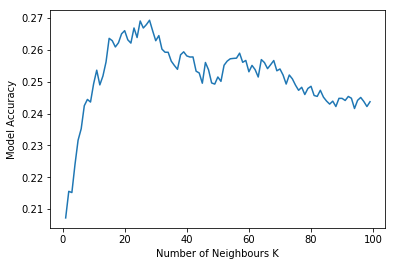

 Test score with k=28: 0.2701 
 Test score with k=5: 0.2356
 Train score with k=28: 0.3292 
 Train score with k=5: 0.4516


In [39]:
#Determine best k
optimal_k = neighbours[cv_scores.index(max(cv_scores))]
print (f'The optimal number of neighbours is {optimal_k}')

# plot model accuracy vs k
plt.plot(neighbours, cv_scores)
plt.xlabel('Number of Neighbours K')
plt.ylabel('Model Accuracy')
plt.show()
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train,y_train)
print(f' Test score with k=28: {knn.score(X_test,y_test):.4f} \n Test score with k=5: {test_score_knn:.4f}')
print(f' Train score with k=28: {knn.score(X_train,y_train):.4f} \n Train score with k=5: {train_score_knn:.4f}')

As one can see, by tuning the number of neighbours K by using cross-validation, I was able to both improve the model accuracy and reduce the effect of overfitting (the model now predicts both train and test sets with similar accuracy).

For the second model with tunable hyperparameter, I chose Least Absolute Shrinkage and Selection Operator - LASSO. It is very similar to Linear regression, but has a tendency to prefer solutions with fewer parameters, effectively reducing the number of variables upon which the given solution is dependent.
If alpha==0, then the model behaves like simple Linear regression. If alpha->infinity, then all coefficients go to 0.

Let's start with alpha==0.1 for my LASSO model. 

In [40]:
las =Lasso(alpha=0.1)
#Train the algorythm
las.fit(X_train, y_train)
#Evaluate prediction
tic = time.time()
y_pred_las = las.predict(X_test)
toc = time.time()
print(f'{(toc-tic)*1000:.4f} ms elapsed')
train_score=las.score(X_train, y_train)
test_score=las.score(X_test, y_test)
mae_las = mean_absolute_error(y_test, y_pred_las)
print(f'Mean absolute error: {mae_las:.4f} Prediction score: {test_score:.4f}')
#dict(zip(list(X_train.columns),las.coef_))
print(f'Train score: {train_score:.4f}')

9.6376 ms elapsed
Mean absolute error: 1.9527 Prediction score: 0.2931
Train score: 0.3204


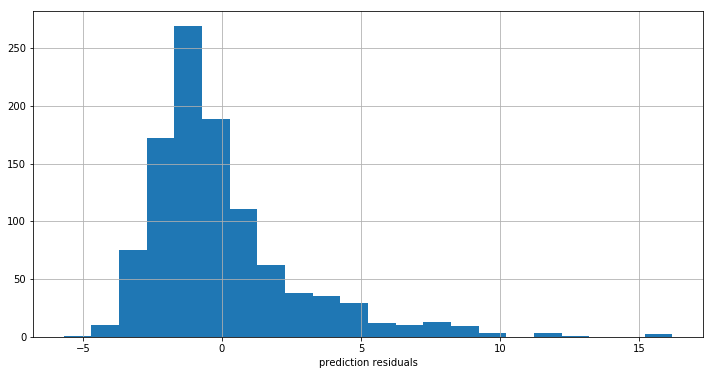

In [41]:
draw_res_hist(y_test,y_pred_las)

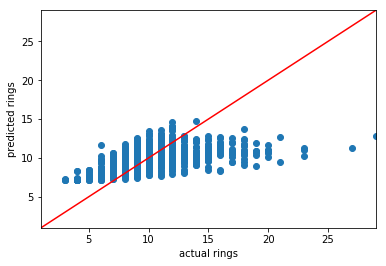

In [42]:
draw_pred_act(y_test,y_pred_las)

One can see that LASSO model with alpha==0.1 is not very effective in predicting the no. of rings. Let's tune this parameter by cross-validation.

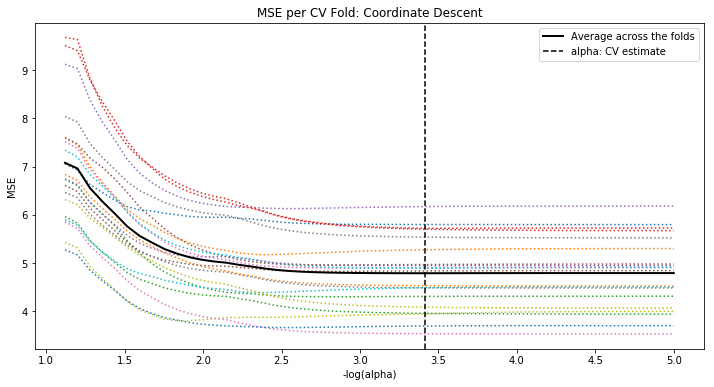

Optimal alpha value: 0.00038338


In [43]:
#LASSO cross-validation (hyperparameter: alpha)
alphas=np.empty(shape=50)
for _ in range(0,50):
    alphas[_]=(1e-5)*1.2**_
lasCV = LassoCV(cv=20,alphas=alphas).fit(X_train, y_train)
m_log_alphas = -np.log10(lasCV.alphas_)
plt.figure(figsize=(12,6))
ax = plt.axes()
ax.plot(m_log_alphas, lasCV.mse_path_, ':')
ax.plot(m_log_alphas, lasCV.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
ax.axvline(-np.log10(lasCV.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
ax.legend()
ax.set_xlabel('-log(alpha)')
ax.set_ylabel('MSE')
ax.set_title('MSE per CV Fold: Coordinate Descent')
ax.axis('tight')
plt.show()
print(f'Optimal alpha value: {lasCV.alpha_:.8f}')

In [44]:
las =Lasso(alpha=lasCV.alpha_)
#Train the algorythm
las.fit(X_train, y_train)
#Evaluate prediction
tic = time.time()
y_pred_las = las.predict(X_test)
toc = time.time()
print(f'{(toc-tic)*1000:.4f} ms elapsed')
train_score=las.score(X_train, y_train)
test_score=las.score(X_test, y_test)
mae_las = mean_absolute_error(y_test, y_pred_las)
print(f'Mean absolute error: {mae_las:.4f} Prediction score: {test_score:.4f}')
#dict(zip(list(X_train.columns),las.coef_))
print(f'Train score: {train_score:.4f}')

0.5882 ms elapsed
Mean absolute error: 1.5838 Prediction score: 0.5381
Train score: 0.5448


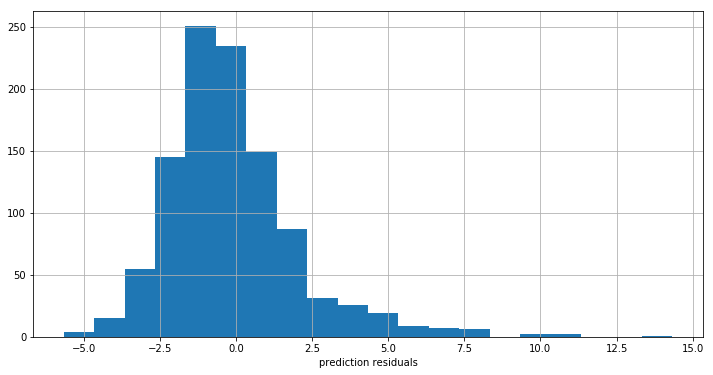

In [45]:
draw_res_hist(y_test,y_pred_las)

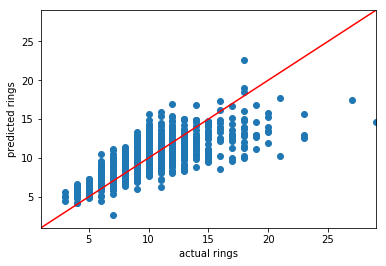

In [46]:
draw_pred_act(y_test,y_pred_las)

With alpha parameter tuned with cross-validation, the LASSO model predicts no. of rings with higher accuracy. However, the initial value of alpha was just a guess.<br>
As LASSO is a method widely used for avoiding overfitting, it is hard to conclude if cross-validation helps regarding this issue in this case. But for sure it was easier and faster to find a correct value for alpha by CV method.

### Conclusions:
Within this task I examined the data, prepared it for modeling, used in total 3 supervised learning algorythms:<br>
1. K Nearest Neighbours
2. Linear Regression
3. Least Absolute Shrinkage and Selection Operator.
I also used dimensional reduction and cross-validation.

In case of abalone dataset, Linear regression turns out to be the most accurate.
PCA is a great way to speep up computation while retaining very good prediction score.
Cross-validation is very useful for tuning hyperparameters.


### Resources used:
Data Science from Scratch - Joel Grus<br>
Introduction to Machine Learning with Python - Andreas C. Mueller, Sarah Guido<br>
Official scikit-learn documentation<br>
http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html<br>
http://seaborn.pydata.org/examples/many_pairwise_correlations.html<br>
https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/#exploring-knn-in-code<br>
https://www.kaggle.com/sriram1204/abalone-machine-learning-insights<br>
https://ericstrong.org/predicting-abalone-rings-part-1/<br>
https://ericstrong.org/predicting-abalone-rings-part-2/<br>
Wikipedia

In [60]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
        
f = open('requirements.txt','w')
for r in requirements:
    f.write("{}=={}".format(*r))
    f.write('\n')
    print("{}=={}".format(*r),'\n')
f.close()

seaborn==0.9.0 

scikit-learn==0.20.0 

pandas==0.23.4 

numpy==1.15.4 

matplotlib==3.0.2 

